# `grf` acic18 example

From https://github.com/grf-labs/grf/blob/master/experiments/acic18, lightly adapted for Jupyter.

## README

*This folder has replication files for the paper "Estimating Treatment Effects with Causal Forests: An Application", by Athey and Wager. The paper was written following a workshop organized at the 2018 Atlantic Causal Inference Conference, "Empirical Investigation of Methods for Heterogeneity". Below is a note from the workshop organizers describing the dataset (the note has been lightly edited to remove irrelevant logistical details).*

The attached dataset is based on preliminary data extracted from the National Study of Learning Mindsets (http://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/). This is a study that evalutes a "nudge-like"  intervention to change student behavior at very low cost, but seeks to understand heterogeneity in the intervention. The main goal of the study is to test for heterogeneity in the effect of an intervention designed to instill students with a "growth mindset". A growth mindset is the belief that intelligence can be developed. It is contrasted with a fixed mindset: the belief that intelligence is a fixed trait that is set in stone at birth. (http://mindsetscholarsnetwork.org/learning-mindsets/growth-mindset/). Because growth mindset interventions only teach students to see their school differently, but don't try to change schools themselves, then growth mindset interventions are thought to depend in important ways on the school context. But research has not yet interrogated treatment effect heterogeneity sufficiently. 

The National Study of Learning Mindsets was a randomized controlled trial in a national probability sample of U.S. public high schools. For the purpose of this workshop we created a dataset that instead emulates an observational study with similar characteristics as the National Study (including covariate distributions, data structures, and effect sizes).  Attached is a dataset of about 10,000 students in 76 schools with a simulated outcome Y (a continuous measure of achievement), a binary treatment variable Z indicating receipt of the intervention, and the following 10 covariates at both the student and school level:

- S3 - Students' self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment
- C1 - Categorical variable for student race/ethnicity
- C2 - Categorical variable for student identified gender
- C3 - Categorical variable for student first-generation status (i.e. first in family to go to college)
- XC - School-level categorical variable for urbanicity of the school (i.e. rural, suburban, etc.)
- X1 - School-level mean of students' fixed mindsets, reported prior to random assignment
- X2 - School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
- X3 - School racial/ethnic minority composition -- i.e. % black, latino, or native/american
- X4 - School poverty concentration -- i.e. % of students who are from families whose incomes fall below the federal poverty line
- X5 - School size - Total # of students in all four grade levels in the school

The main research questions to be addressed include:

1. Was the mindset intervention effective in improving student achievement?
2. Researchers hypothesize that the effect of the intervention is moderated by school level achievement (X2) and pre-existing mindset norms (X1). In particular there are two competing hypotheses about how X2 moderates the effect of the intervention: Either it is largest in middle-achieving schools (a "Goldilocks effect") or is decreasing in school-level achievement
3. Researchers also collected other covariates and are interested in exploring their possible role in moderating treatment effects.

In your analysis we would ask you to address the the three research questions above. Please recall from our initial invitation that this is not intended to be a "bake off", but rather an opportunity to understand the strengths and weaknesses of methods for addressing important scientific questions, such as those arising in the Mindset Study.  As such we are particularly interested in comments on how you think your chosen methods are either well-suited or require further development to address each of the questions above, rather than specific estimates and/or tests.

Finally, we have worked with the editor of Observational Studies to create a special issue summarizing the findings of this workshop. To that end, all panelists are invited to submit a writeup of their results and comments.

We are looking forward to seeing you all there! This should be fun.

Best,

Carlos Carvalho, Jared Murray, Jennifer Hill and Avi Feller.

NOTE: The dataset may only be used to evaluate methods for inferring treatment effects. Analysis of or publication using other features of the joint distribution of the covariates (the S, C and X variables) are expressly prohibited (and ill adivsed, as noise has been added to the other variables). Any publication using the dataset for its intended purpose should cite the National Study.

## Setup

In [1]:
library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units



In [2]:
set.seed(1)

In [3]:
data.all = read.csv("https://raw.githubusercontent.com/grf-labs/grf/master/experiments/acic18/synthetic_data.csv")

## Preprocess

In [4]:
data.all$schoolid = factor(data.all$schoolid)

DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

## Model

It appears that school ID does not affect pscore. So ignore it in modeling, and just treat it as source of per-cluster error.

In [5]:
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [6]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)

Grow a forest. Add extra trees for the causal forest.

In [7]:
Y.forest = regression_forest(X, Y, clusters = school.id)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   samples_per_cluster = 50,
                   tune.parameters = TRUE)
tau.hat = predict(cf)$predictions

Estimate ATE.

In [8]:
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.246 +/- 0.041"

### Omnibus tests for heterogeneity.

Run best linear predictor analysis.

In [9]:
test_calibration(cf)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>|t|)    
mean.forest.prediction         1.025807   0.084888 12.0842   <2e-16 ***
differential.forest.prediction 0.087612   0.353409  0.2479   0.8042    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Compare regions with high and low estimated CATEs.

In [10]:
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))

[1] "95% CI for difference in ATE: 0.014 +/- 0.071"

Formal test for X1 and X2.

In [11]:
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.08, df = 71.737, p-value = 0.002934
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19736626 -0.04226149
sample estimates:
mean of x mean of y 
0.1865262 0.3063401 


In [12]:
school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])


	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.99539, df = 72.156, p-value = 0.3229
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04096335  0.12267512
sample estimates:
mean of x mean of y 
0.2668611 0.2260052 


In [13]:
school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))

                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0851 0.04255   1.342  0.268
Residuals        73 2.3153 0.03172               

Formal test for S3.

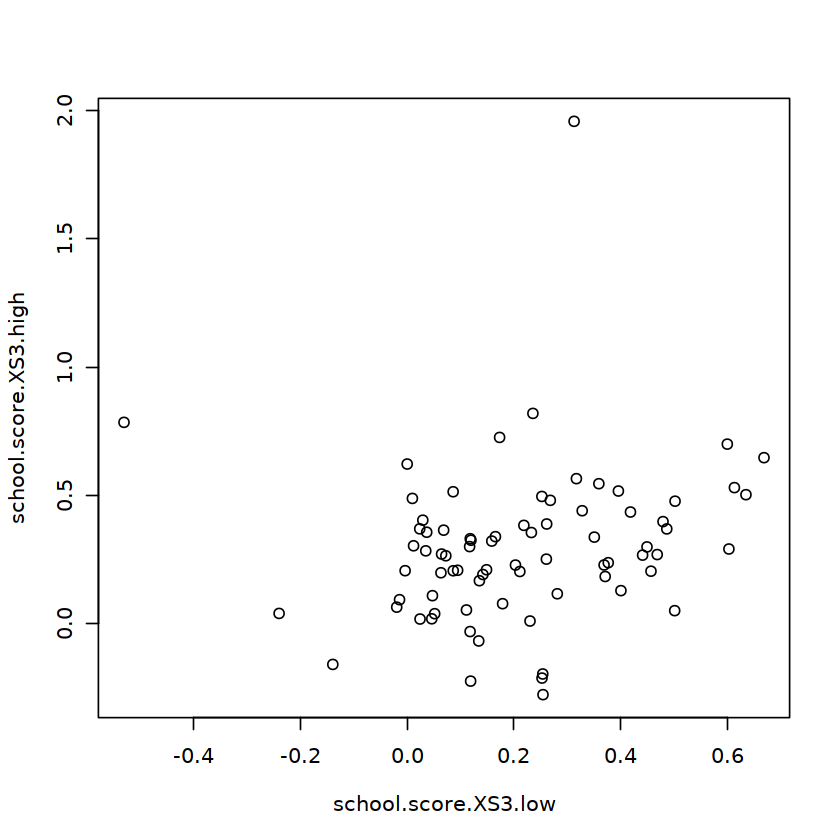

In [14]:
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)

In [15]:
t.test(school.score.XS3.high - school.score.XS3.low)


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.1588, df = 75, p-value = 0.03406
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.006374982 0.158741636
sample estimates:
 mean of x 
0.08255831 


Look at school-wise heterogeneity.

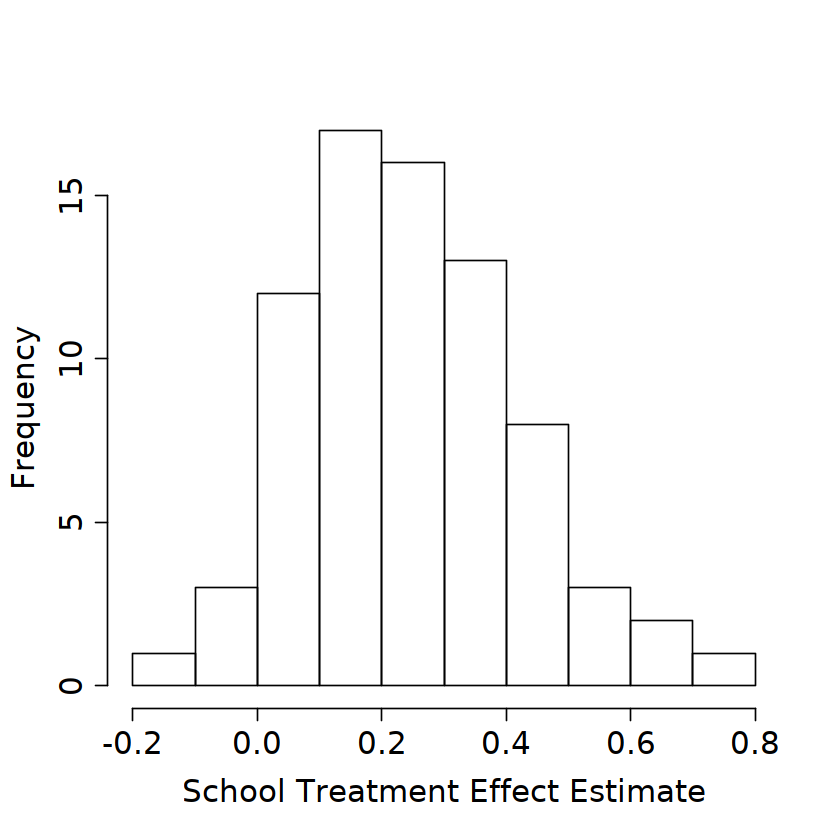

In [16]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")

Re-check ATE...sanity check only.

In [17]:
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.246 +/- 0.04"


Look at variation in propensity scores.

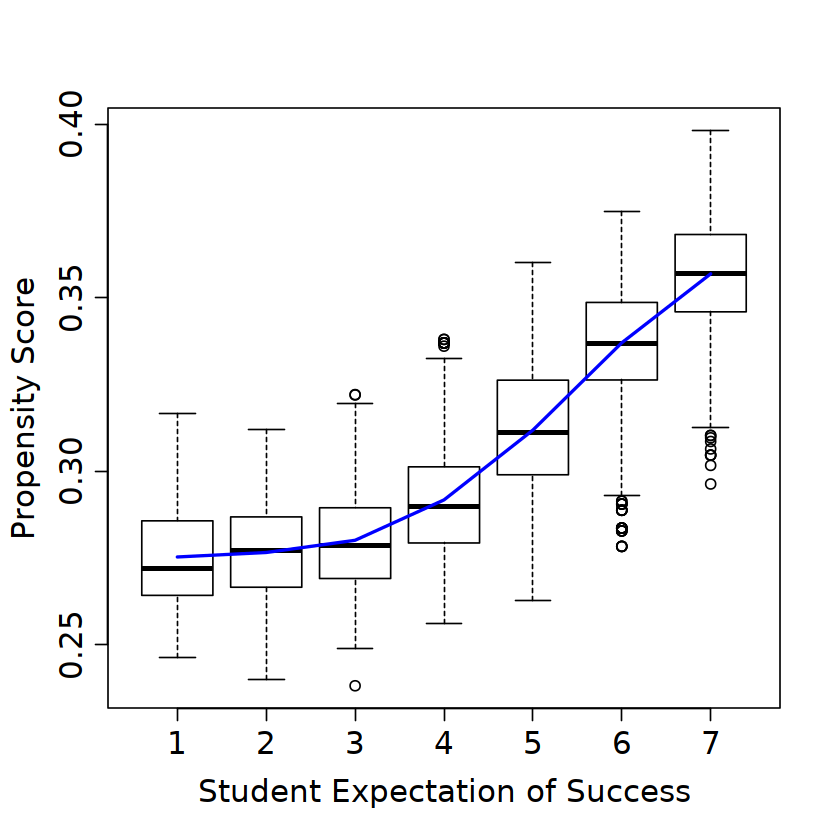

In [18]:
DF = X
DF$W.hat = cf$W.hat

pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)

### Analysis ignoring clusters

In [19]:
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = TRUE)

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

[1] "95% CI for the ATE: 0.253 +/- 0.022"

In [20]:
test_calibration(cf.noclust)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>|t|)    
mean.forest.prediction         1.009655   0.044939 22.4674 < 2.2e-16 ***
differential.forest.prediction 0.454414   0.101662  4.4699  7.91e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


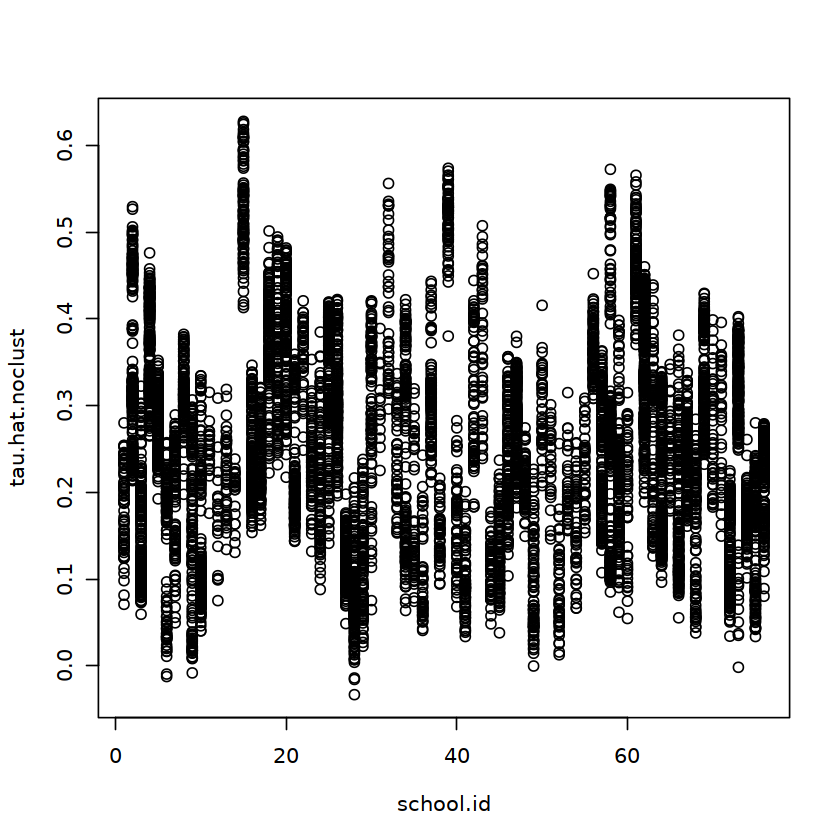

In [21]:
tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

In [22]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = TRUE)
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [23]:
cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>|t|)    
mean.forest.prediction         0.995383   0.083006 11.9918   <2e-16 ***
differential.forest.prediction 0.137480   0.302759  0.4541   0.6498    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [24]:
Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

[1]  4.905887e-05 -2.882562e-05

In [25]:
summary(aov(dr.score ~ factor(school.id)))

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    208   2.775    2.04 3.28e-07 ***
Residuals         10315  14032   1.360                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Analysis without fitting the propensity score.

In [26]:
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = TRUE,
                          samples_per_cluster = 50,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

[1] "95% CI for the ATE: 0.254 +/- 0.04"

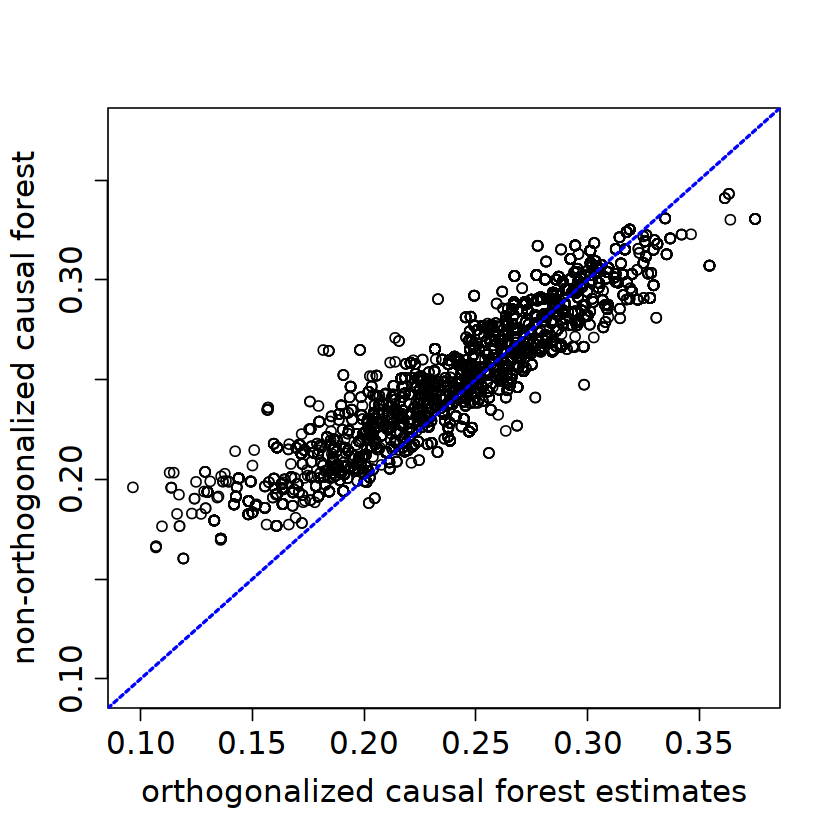

In [27]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

Train forest on school-wise DR scores.

In [28]:
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>|t|)    
mean.forest.prediction         1.001559   0.084023 11.9200   <2e-16 ***
differential.forest.prediction 0.846987   0.629597  1.3453   0.1826    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Alternative OLS analysis.

In [29]:
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2438803  0.0774760  3.1478  0.00247 **
X1          -0.0512500  0.0296368 -1.7293  0.08844 . 
X2           0.0141887  0.0340206  0.4171  0.67799   
X3           0.0102804  0.0269382  0.3816  0.70396   
X4           0.0259632  0.0257395  1.0087  0.31681   
X5          -0.0341360  0.0271531 -1.2572  0.21312   
XC.1        -0.0025293  0.0941907 -0.0269  0.97866   
XC.2         0.0846827  0.1055514  0.8023  0.42527   
XC.3        -0.1420450  0.0879102 -1.6158  0.11091   
XC.4         0.0409140  0.0824739  0.4961  0.62148   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Make some plots...

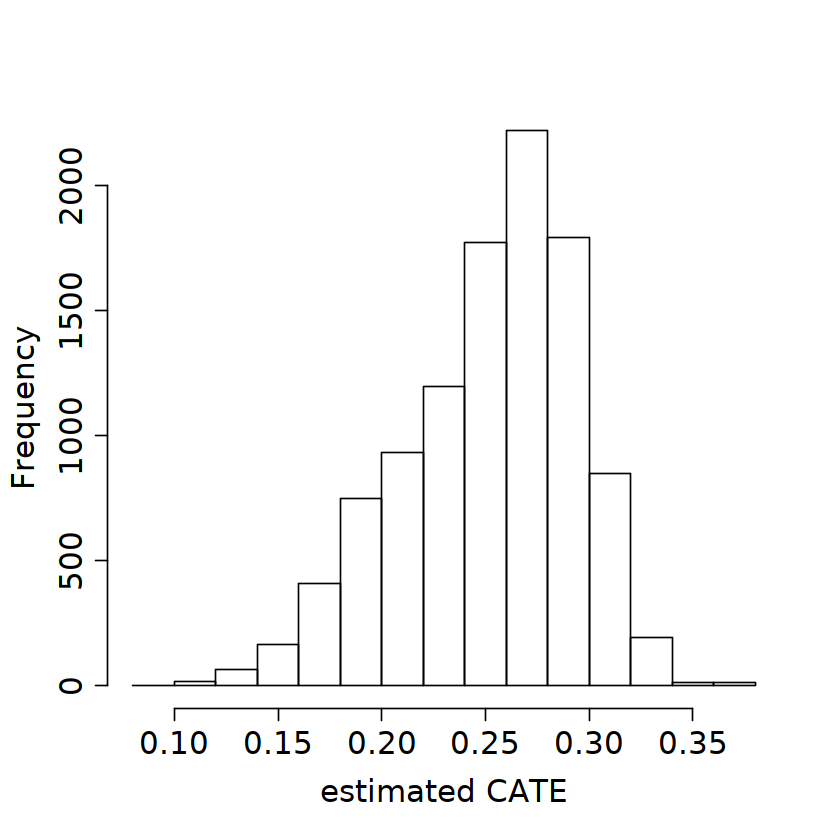

In [30]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")

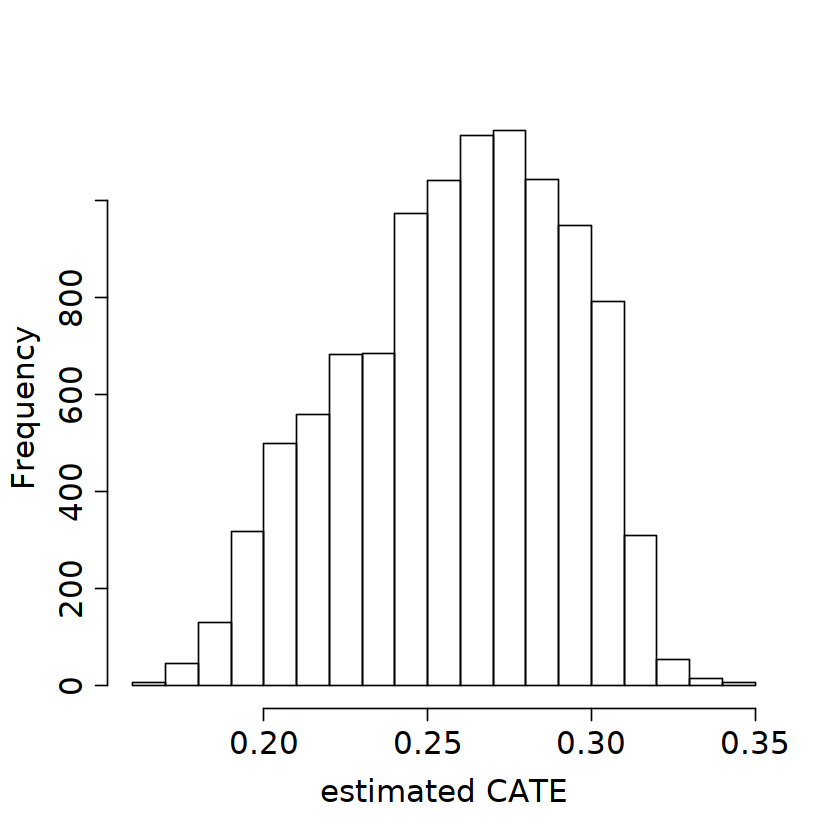

In [31]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")

In [32]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))

ERROR: Error in hist.default(tau.hat.noclust, xlab = "estimated CATE", main = "", : some 'x' not counted; maybe 'breaks' do not span range of 'x'


In [ ]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)

In [ ]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)

In [ ]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

Experiment with no orthogonalization.

In [ ]:
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

In [ ]:
cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

Visualize school-level covariates by treatment heterogeneity.

In [ ]:
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())

In [ ]:
mean(school.X$XC.3)

In [ ]:
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

CATE by school.

In [ ]:
ord = order(order(school.pred))
school.sort = ord[school.id]

pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef